In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-multilearn==0.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.7 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf

# Disable GPU (if available)
tf.config.set_visible_devices([], 'GPU')

# Or, you can specify the CPU device explicitly
# tf.config.set_visible_devices([], 'GPU:0')

# Now TensorFlow will use only the CPU

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from skmultilearn.adapt import MLkNN
import sklearn.metrics as metrics
from sklearn.metrics import hamming_loss, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import multilabel_confusion_matrix
import os

In [ ]:
os.chdir('/content/drive/MyDrive/ICON/Hindi')
cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in '/content/drive/.shortcut-targets-by-id/1nib99g_6T0IHcULEnV0SoCt0-hrkM0yM/Hindi': ['hindi_combined_hate_MACD.csv', 'train_hi_l1_modded.csv', 'glove', 'CNN_BiLSTM_ICON_Task-2_Hindi_Binary_Classification.h5', 'Hindi_Task2_output.csv', 'New_CNN+BiLSTM_Attempt-2_Hindi.ipynb']


In [ ]:
d2 = pd.read_csv('train_hi_l1_modded.csv')
d2 = d2.drop(['key', 'hi_a1', 'hi_a2', 'hi_a3', 'hi_a4', 'hi_a5'], axis=1)
d2['label'] = d2['label'].astype(int)
d2 = d2[['label', 'text']]
d2

,label,text
0,0,भारत में तीन किसान कानून बिल वापस लेने पर भक्त...
1,0,राजस्थान अजीबोगरीब: गांव की खुशहाली के लिए रा...
2,0,सलमान ने की राखी के विरोधी की वकालत तो 'आइटम ग...
3,0,!!हर शब्द अमॄतम!! पुरानी एक कहावत है... टूटी ...
4,1,"""PM मोदी जी "" की माँ के लिए अपशब्द कहने वाला द..."
...,...,...
6192,0,"😎 काम वाली बाई का फोन आया, पत्नि को। कामवाली ..."
6193,0,😎😎ग्रुप में चर्चा चल रही थी कि 21 दिन के लॉक ड...
6194,0,🚩 🔱▁▂▄▅▆▇█🦁█▇▆▅▄▂▁🔱 🔱⚜️👉 School में हमें स...
6195,0,"🚩 #लंका का जिहादी डॉक्टर,हजारों हिंदू महिलाओं ..."


The label column is created in the original training dataset by taking the majority occurence of 0 or 1 among all the 5 annotators in columns - 'hi_a1', 'hi_a2', 'hi_a3', 'hi_a4', 'hi_a5'.

In [ ]:
df = d2
df

,label,text
0,0,भारत में तीन किसान कानून बिल वापस लेने पर भक्त...
1,0,राजस्थान अजीबोगरीब: गांव की खुशहाली के लिए रा...
2,0,सलमान ने की राखी के विरोधी की वकालत तो 'आइटम ग...
3,0,!!हर शब्द अमॄतम!! पुरानी एक कहावत है... टूटी ...
4,1,"""PM मोदी जी "" की माँ के लिए अपशब्द कहने वाला द..."
...,...,...
6192,0,"😎 काम वाली बाई का फोन आया, पत्नि को। कामवाली ..."
6193,0,😎😎ग्रुप में चर्चा चल रही थी कि 21 दिन के लॉक ड...
6194,0,🚩 🔱▁▂▄▅▆▇█🦁█▇▆▅▄▂▁🔱 🔱⚜️👉 School में हमें स...
6195,0,"🚩 #लंका का जिहादी डॉक्टर,हजारों हिंदू महिलाओं ..."


## Word Pre-Processing

In [ ]:
## Word Pre-Processing ##
import nltk
import string
import re

## Function to normalize text for pre-processing ##
def normalize_text(text):
  emoji_pattern = re.compile("["
                              u"\U0001F600-\U0001F64F"  # emoticons
                              u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                              u"\U0001F680-\U0001F6FF"  # transport & map symbols
                              u"\U0001F700-\U0001F77F"  # alchemical symbols
                              u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                              u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                              u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                              u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                              u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                              u"\U00002702-\U000027B0"  # Dingbats
                              u"\U000024C2-\U0001F251"
                              "]+", flags=re.UNICODE)
  text = text.lower()
  text = re.sub('\[.*?\]', ' ', text)
  text = re.sub('https?://\S+|www\.\S+', ' ', text)
  text = re.sub('<.*?>+', ' ', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
  text = re.sub('\n', ' ', text)
  text = re.sub('\w*\d\w*', ' ', text)
  text = re.sub('<handle replaced>', '', text)
  text = emoji_pattern.sub(r'', text)
  return text


In [ ]:
## Apply the written function ##
df['text'] = df['text'].apply(lambda x: normalize_text(x))
df

,label,text
0,0,भारत में तीन किसान कानून बिल वापस लेने पर भक्त...
1,0,राजस्थान अजीबोगरीब गांव की खुशहाली के लिए रा...
2,0,सलमान ने की राखी के विरोधी की वकालत तो आइटम ग...
3,0,हर शब्द अमॄतम पुरानी एक कहावत है टूटी ...
4,1,pm मोदी जी की माँ के लिए अपशब्द कहने वाला द...
...,...,...
6192,0,काम वाली बाई का फोन आया पत्नि को। कामवाली ...
6193,0,ग्रुप में चर्चा चल रही थी कि दिन के लॉक डाउन...
6194,0,school में हमें सती प्रथा घूंघट प्रथा ...
6195,0,लंका का जिहादी डॉक्टर हजारों हिंदू महिलाओं क...


# Train Test Splits

In [ ]:
X = list(df['text'])
#y = np.asarray(d1[d1.columns[1:]])
y_data = df['label']
y = y_data.values

In [ ]:
len(X)

6197

In [ ]:
y.size

6197

In [ ]:
X

['भारत में तीन किसान कानून बिल वापस लेने पर भक्तों की जो हालत हुई अब यह किसी से छुपा नहीं है उसके इलावा जो टट्टी खोर पत्रकार थे उनकी भी हालत खराब हुई है किसी को मुंह दिखाने के लायक नहीं है अब यह लोग यहां तक कि अपने घर में भी मुंह दिखाने के लायक नहीं रहे।',
 'राजस्थान  अजीबोगरीब  गांव की खुशहाली के लिए रात भर किन्नर करते है यह काम   ',
 'सलमान ने की राखी के विरोधी की वकालत तो  आइटम गर्ल  ने दी धमकी   rakhisawant  salmankhan',
 '  हर शब्द अमॄतम    पुरानी एक कहावत है    टूटी की नही बनी है बूटी  झूठी की नहीं कोई भी खूॅंटी  फूटी को क्या करेगा सूठी  रूठी तो बने काली कलूटी   अर्थात  जिस व्यक्ति का आत्मविश्वास अंदर से टूट जाये उसको ठीक करने की कोई बूटी यानी ओषधि या दवा आज तक सन्सार में नहीं बनी है।  amrutam',
 ' pm मोदी जी   की माँ के लिए अपशब्द कहने वाला दोगला भड़वा राजबब्बर वास्तव में किसी रंडी की ही औलाद होगा  हरामी साला रंडी का दल्ला',
 ' pappu बस में खड़ा था   अचानक ब्रेक लगी तो एक लड़की पर गिर पडा                      लड़की    ने थप्पड़ मरते हुये कहाँ बत्तमीज़  क्या कर रहे हो            

In [ ]:
y

array([0, 0, 0, ..., 0, 0, 0])

# Model CNN & Bi-LSTM

In [ ]:
#Model CNN & Bi-LSTM
import keras
from keras.preprocessing.text import one_hot
from keras.utils import pad_sequences
#from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM
# from keras.layers.recurrent import LSTM
# from keras.layers.core import Activation, Dropout, Dense
from keras.layers import LSTM, Activation, Dropout, Dense, Flatten, Bidirectional, GRU, concatenate, SpatialDropout1D

from keras.layers import Flatten, LSTM
from keras.layers import Bidirectional,GRU,concatenate,SpatialDropout1D
from keras.layers import GlobalMaxPooling1D,GlobalAveragePooling1D,Conv1D
from keras.models import Model
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers import Concatenate
import matplotlib.pyplot as plt
from keras import layers
from keras.optimizers import Adam,SGD,RMSprop
from keras.losses import MeanSquaredError
######## Textual Features for Embedding ###################
max_len = 100
max_features = 10000
embed_size = 300
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X))
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, padding='post', maxlen=max_len)

In [ ]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
X

array([[  63,    5,  896, ...,    0,    0,    0],
       [ 629, 8331, 1047, ...,    0,    0,    0],
       [1783,   21,    3, ...,    0,    0,    0],
       ...,
       [   5,  357, 4739, ...,    0,    0,    0],
       [7806,    6,  201, ...,    0,    0,    0],
       [ 205,  205, 8227, ...,    0,    0,    0]], dtype=int32)

In [ ]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
from keras.utils import to_categorical
y = to_categorical(y, num_classes=2)
y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
os.chdir('/content/drive/MyDrive/ICON/Hindi/glove')
cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in '/content/drive/.shortcut-targets-by-id/1nib99g_6T0IHcULEnV0SoCt0-hrkM0yM/Hindi/glove': ['hi-d300-vocab.txt', 'hi-d300-glove.txt']


In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('/content/drive/MyDrive/ICON/Hindi/glove/hi-d300-glove.txt', encoding="utf8", errors='ignore') ## using pre-trained or self-trained embeddings ##

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

vocab_size = len(tokenizer.word_index) + 1  ## total distinct words is the Vocabulary ##
word_index = tokenizer.word_index
num_words = min(max_features,len(word_index)+1)

embedding_matrix = zeros((num_words, embed_size)) ## has to be similar to glove dimension ##
for word, index in tokenizer.word_index.items():
    if index >= max_features:
        continue
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Model Training

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, SpatialDropout1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

# Load your data, assuming you have a DataFrame 'df' with 'text' and 'label' columns
# Ensure that the 'label' column contains 'neither,' 'racist,' or 'sexist'

# Split your data into features (X) and labels (y)
# X = d2['text'].values
# y = d2['label'].values

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize a list to store classification reports for each fold
classification_reports = []
# Initialize lists to store metrics for each fold
precision_list = []
recall_list = []
f1_score_list = []

# # Define the maximum number of words to consider in the text
# max_words = 10000

# # Tokenize the text data
# tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
# tokenizer.fit_on_texts(X)

# # Convert text data to sequences
# X_sequences = tokenizer.texts_to_sequences(X)

# # Define the maximum sequence length (adjust as needed)
# max_sequence_length = 100

# Convert labels to categorical (one-hot encoding)
# y_encoded = to_categorical(y, num_classes=3)

# Iterate through the folds
# import pdb;pdb.set_trace()
for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Define the model architecture
    sequence_input = Input(shape=(max_len, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable = False)(sequence_input)
    x = SpatialDropout1D(0.2)(x) ## ostly drops the entire 1D feature map rather than individual elements.
    x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "glorot_uniform")(x)
    # x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "glorot_uniform")(x)
    #x = Conv1D(16, kernel_size = 2, padding = "valid", kernel_initializer = "glorot_uniform")(x)
    x = Bidirectional(LSTM(128, return_sequences=True,dropout=0.2,recurrent_dropout=0.1))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    x = Dense(128,activation='relu')(avg_pool)
    x = Dropout(0.2)(x)
    preds = Dense(2, activation="softmax")(x)
    model = Model(sequence_input, preds)
    # model.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=1e-3),metrics=['acc'])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#     model = Sequential()
#     model.add(Embedding(input_dim=max_words, output_dim=100, input_length=max_sequence_length))
#     model.add(SpatialDropout1D(0.2))
#     model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.1)))
#     model.add(GlobalAveragePooling1D())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(3, activation="softmax"))

#     # Compile the model
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    epochs = 5
    batch_size = 32
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1)

    # Evaluate the model on the validation data
    y_pred = model.predict(X_val)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_val_labels = np.argmax(y_val, axis=1)

#     # Generate and store the classification report for this fold
#     report = classification_report(y_val_labels, y_pred_labels, target_names=['neither', 'racist', 'sexist'])
#     classification_reports.append(report)

#     print(f'Fold {fold + 1} - Classification Report:\n{report}\n')

# # Print the average classification report across all folds
# average_report = '\n'.join(classification_reports)
# print(f'Average Classification Report Across {n_splits} Folds:\n{average_report}')
     # Generate the classification report for this fold
    report = classification_report(y_val_labels, y_pred_labels, target_names=['Hate', 'Not Hate'], output_dict=True)

    # Extract precision, recall, and f1-score
    precision_list.append(report['weighted avg']['precision'])
    recall_list.append(report['weighted avg']['recall'])
    f1_score_list.append(report['weighted avg']['f1-score'])

    print(f'Fold {fold + 1} - Classification Report:\n{classification_report(y_val_labels, y_pred_labels, target_names=["Hate", "Not Hate"])}\n')

# Calculate the average precision, recall, and f1-score across all folds
average_precision = np.mean(precision_list)
average_recall = np.mean(recall_list)
average_f1_score = np.mean(f1_score_list)

# Display the average classification report
average_report = f'Average Precision: {average_precision:.2f}\nAverage Recall: {average_recall:.2f}\nAverage F1-Score: {average_f1_score:.2f}'
print(f'Average Classification Report Across {n_splits} Folds:\n{average_report}')

Epoch 1/5
97/97 [==============================] - 75s 667ms/step - loss: 0.6047 - accuracy: 0.7085 - val_loss: 0.5808 - val_accuracy: 0.7180
Epoch 2/5
97/97 [==============================] - 59s 608ms/step - loss: 0.5732 - accuracy: 0.7098 - val_loss: 0.5459 - val_accuracy: 0.7335
Epoch 3/5
97/97 [==============================] - 64s 659ms/step - loss: 0.5552 - accuracy: 0.7301 - val_loss: 0.5425 - val_accuracy: 0.7431
Epoch 4/5
97/97 [==============================] - 64s 658ms/step - loss: 0.5370 - accuracy: 0.7527 - val_loss: 0.5453 - val_accuracy: 0.7335
Epoch 5/5
97/97 [==============================] - 6s 59ms/step
Fold 1 - Classification Report:
              precision    recall  f1-score   support

        Hate       0.76      0.95      0.84      2216
    Not Hate       0.66      0.26      0.37       883

    accuracy                           0.75      3099
   macro avg       0.71      0.60      0.61      3099
weighted avg       0.73      0.75      0.71      3099


Epoch 1/

In [ ]:
model.save('/content/CNN_BiLSTM_ICON_Task-3_Hindi_Binary_Classification.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


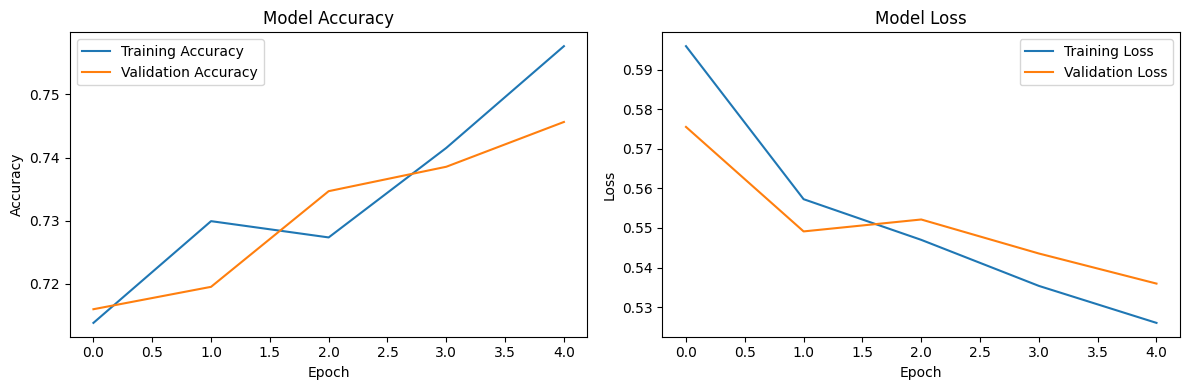

In [ ]:
# Assuming you have trained your model and have a `history` object
# after fitting the model

import matplotlib.pyplot as plt

# Plot accuracy and loss graphs
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# Assuming you have `y_val_labels` and `y_pred_labels` as the true and predicted labels

# Compute F1 score, precision, and recall
f1 = f1_score(y_val_labels, y_pred_labels, average='weighted')
precision = precision_score(y_val_labels, y_pred_labels, average='weighted')
recall = recall_score(y_val_labels, y_pred_labels, average='weighted')

print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(report)

F1 Score: 0.6975154815038289
Precision: 0.7288173337767936
Recall: 0.7456423499031634
{'Hate': {'precision': 0.7541979278313683, 'recall': 0.9547715965626413, 'f1-score': 0.8427145708582834, 'support': 2211}, 'Not Hate': {'precision': 0.6655518394648829, 'recall': 0.22435174746335965, 'f1-score': 0.33558178752107926, 'support': 887}, 'accuracy': 0.7456423499031634, 'macro avg': {'precision': 0.7098748836481257, 'recall': 0.5895616720130005, 'f1-score': 0.5891481791896813, 'support': 3098}, 'weighted avg': {'precision': 0.7288173337767936, 'recall': 0.7456423499031634, 'f1-score': 0.6975154815038289, 'support': 3098}}


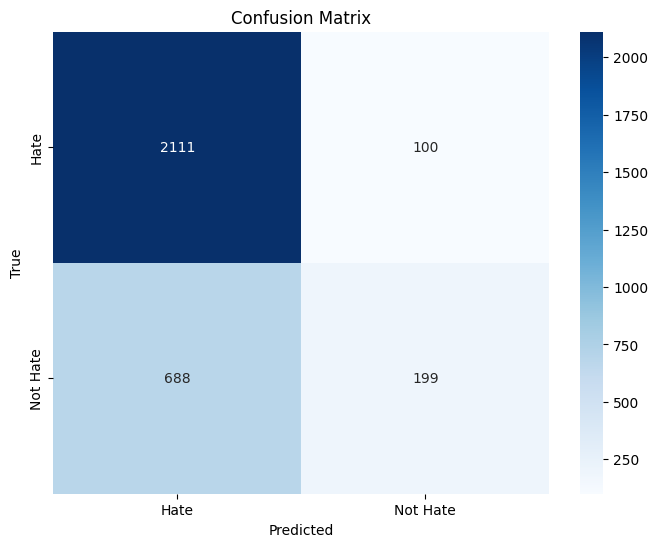

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have true labels (y_true) and predicted labels (y_pred)
# y_true = true_labels
# y_pred = predicted_labels

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_val_labels, y_pred_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Hate','Not Hate'],
            yticklabels=['Hate','Not Hate'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Testing on Unseen Data

In [ ]:
vv= pd.read_csv('/content/test_label1.csv')
vv

,id,text,language,key
0,1,"""who's this tweet about"" bitch it's about you ...",english,question_1
1,2,#AlkaLamba should’ve used her slippers to slap...,english,question_1
2,3,#CoronaVillains #COVIDIDIOT #COVID2019 is a...,english,question_1
3,4,"(Acts 29:19994) LIKE the female ""governors"" of...",english,question_1
4,5,***Let us celebrate “secular” as a beautiful w...,english,question_1
...,...,...,...,...
3753,3754,😂😂😂 ஊம்பு,tamil,question_1
3754,3755,"😄 தமிழ் தெரிஞ்சவன்""தான் உங்கொம்மால குண்டி அடிக...",tamil,question_1
3755,3756,😅😅😂😂 நீ தான் பங் அவனோலுக்கு கரெக்டா ஆன ஆளு.. 😎...,tamil,question_1
3756,3757,😺✏ — ஆமாம் வேச ஆமாம் வேச அய்ம் ச்லீபின் அய்ம் ...,tamil,question_1


In [ ]:
vv = vv[vv['language'] == 'hindi']
vv

,id,text,language,key
1107,1108,#BandraStation #SharadPawar #Muradabad अगर अभ...,hindi,question_1
1108,1109,#ConspiracyAgainstIndia सुन लो रे देश के गद्द...,hindi,question_1
1109,1110,#MarathaReservation : महाराष्ट्र में जश्न का म...,hindi,question_1
1110,1111,#RheaChakraborty aap Mahesh bhatt se madad kiy...,hindi,question_1
1111,1112,"#SecularMaskOfd हमे पता नहि क्या कहते है ,इतना...",hindi,question_1
...,...,...,...,...
2618,2619,है हैवान लोग होते हैं इनको ओसामा लादेन खतरनाक ...,hindi,question_1
2619,2620,"🇮🇳जय हिन्द,🇮🇳जय भारत,🇮🇳वन्दे मातरम🇮🇳🇮🇳 बघेल तु...",hindi,question_1
2620,2621,🙏जय भीम 🙏 जो लोग हमें धमकियां देते है और संव...,hindi,question_1
2621,2622,🚩🕉🚩 *इंसान के पास 😇दिमाग होना चाहिये* *💀खोपड़...,hindi,question_1


In [ ]:
vv1 = vv
vv1

,id,text,language,key
1107,1108,#BandraStation #SharadPawar #Muradabad अगर अभ...,hindi,question_1
1108,1109,#ConspiracyAgainstIndia सुन लो रे देश के गद्द...,hindi,question_1
1109,1110,#MarathaReservation : महाराष्ट्र में जश्न का म...,hindi,question_1
1110,1111,#RheaChakraborty aap Mahesh bhatt se madad kiy...,hindi,question_1
1111,1112,"#SecularMaskOfd हमे पता नहि क्या कहते है ,इतना...",hindi,question_1
...,...,...,...,...
2618,2619,है हैवान लोग होते हैं इनको ओसामा लादेन खतरनाक ...,hindi,question_1
2619,2620,"🇮🇳जय हिन्द,🇮🇳जय भारत,🇮🇳वन्दे मातरम🇮🇳🇮🇳 बघेल तु...",hindi,question_1
2620,2621,🙏जय भीम 🙏 जो लोग हमें धमकियां देते है और संव...,hindi,question_1
2621,2622,🚩🕉🚩 *इंसान के पास 😇दिमाग होना चाहिये* *💀खोपड़...,hindi,question_1


In [ ]:
## Word Pre-Processing ##
import nltk
import string
import re

## Function to normalize text for pre-processing ##
def normalize_text(text):
  emoji_pattern = re.compile("["
                              u"\U0001F600-\U0001F64F"  # emoticons
                              u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                              u"\U0001F680-\U0001F6FF"  # transport & map symbols
                              u"\U0001F700-\U0001F77F"  # alchemical symbols
                              u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                              u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                              u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                              u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                              u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                              u"\U00002702-\U000027B0"  # Dingbats
                              u"\U000024C2-\U0001F251"
                              "]+", flags=re.UNICODE)
  text = text.lower()
  text = re.sub('\[.*?\]', ' ', text)
  text = re.sub('https?://\S+|www\.\S+', ' ', text)
  text = re.sub('<.*?>+', ' ', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
  text = re.sub('\n', ' ', text)
  text = re.sub('\w*\d\w*', ' ', text)
  text = re.sub('<handle replaced>', '', text)
  text = emoji_pattern.sub(r'', text)
  return text
## Apply the written function ##
vv1['text'] = vv1['text'].apply(lambda x: normalize_text(x))
vv1

<ipython-input-32-01992e7e1f18>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vv1['text'] = vv1['text'].apply(lambda x: normalize_text(x))


,id,text,language,key
1107,1108,bandrastation sharadpawar muradabad अगर अभ...,hindi,question_1
1108,1109,conspiracyagainstindia सुन लो रे देश के गद्द...,hindi,question_1
1109,1110,marathareservation महाराष्ट्र में जश्न का म...,hindi,question_1
1110,1111,rheachakraborty aap mahesh bhatt se madad kiy...,hindi,question_1
1111,1112,secularmaskofd हमे पता नहि क्या कहते है इतना...,hindi,question_1
...,...,...,...,...
2618,2619,है हैवान लोग होते हैं इनको ओसामा लादेन खतरनाक ...,hindi,question_1
2619,2620,जय हिन्द जय भारत वन्दे मातरम बघेल तुझसे देश शर...,hindi,question_1
2620,2621,जय भीम जो लोग हमें धमकियां देते है और संविध...,hindi,question_1
2621,2622,इंसान के पास दिमाग होना चाहिये खोपड़ी तो ...,hindi,question_1


In [ ]:
######## Textual Features for Embedding ###################

sequence = tokenizer.texts_to_sequences(vv1.text)
sequence = pad_sequences(sequence, padding='post', maxlen=max_len)

In [ ]:
sequence = tokenizer.texts_to_sequences(vv1['text']) # same tokenizer which is used on train data.
sequence = pad_sequences(sequence,padding='post', maxlen = max_len)

predictions = model.predict(sequence)
classes=np.argmax(predictions,axis=1)

48/48 [==============================] - 4s 89ms/step


In [ ]:
predictions

array([[0.8275581 , 0.1724419 ],
       [0.505296  , 0.494704  ],
       [0.811686  , 0.18831395],
       ...,
       [0.5789383 , 0.42106172],
       [0.72825074, 0.2717493 ],
       [0.85663444, 0.14336556]], dtype=float32)

In [ ]:
pred = np.argmax(predictions, axis=1)
pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
ids = np.arange(1108, 2624)
# Create a DataFrame with 'id' and 'value' columns
result_df = pd.DataFrame({'id': ids, 'value': pred})
# result_df = pd.DataFrame({'value': predictions})
result_df

,id,value
0,1108,0
1,1109,0
2,1110,0
3,1111,0
4,1112,0
...,...,...
1511,2619,0
1512,2620,0
1513,2621,0
1514,2622,0


In [ ]:
# Save the DataFrame to a CSV file
result_df.to_csv('/content/Hindi_Task3_output.csv', index=False)

Similarly, the output for test_label3.csv is found by simply changing the path.